In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt


import pandas as pd
from sklearn.preprocessing import OneHotEncoder



# STEP 1: train dataset
<hr/>

In [2]:
df_train = pd.read_csv('./Data/split/traning_set.csv')
df_test = pd.read_csv('./Data/split/validation_set.csv')
df_submission = pd.read_csv('./Data/kaggle/test.csv')

In [135]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_submission['date'] = pd.to_datetime(df_submission['date'])

### Feature Engineering and Analysis

#### Input missing dates

In [136]:
# Generate a complete date range based on the minimum and maximum dates in the dataset
min_date = df_train['date'].min()
max_date = df_train['date'].max()
complete_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Identify missing dates
missing_dates = complete_date_range.difference(df_train['date'])
missing_dates


DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [137]:
# Get unique store numbers and families
store_nbrs = df_train['store_nbr'].unique()
families = df_train['family'].unique()
from itertools import product

# Create new rows for each combination of store_nbr, family, and missing date
new_rows = []
for date in missing_dates:
    for store_nbr, family in product(store_nbrs, families):
        new_rows.append({
            'id': len(df_train) + len(new_rows),
            'date': date,
            'store_nbr': store_nbr,
            'family': family,
            'sales': 0.0,
            'onpromotion': 0
        })


In [138]:
new_df = pd.DataFrame(new_rows)
df_train = pd.concat([df_train, new_df], ignore_index=True)

#### Add datetime Features

In [139]:
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day_of_week'] = df_train['date'].dt.day_name()

In [140]:
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day_of_week'] = df_test['date'].dt.day_name()

In [141]:
df_submission['year'] = df_submission['date'].dt.year
df_submission['month'] = df_submission['date'].dt.month
df_submission['day_of_week'] = df_submission['date'].dt.day_name()

#### Searh for Sasonality and Tendency

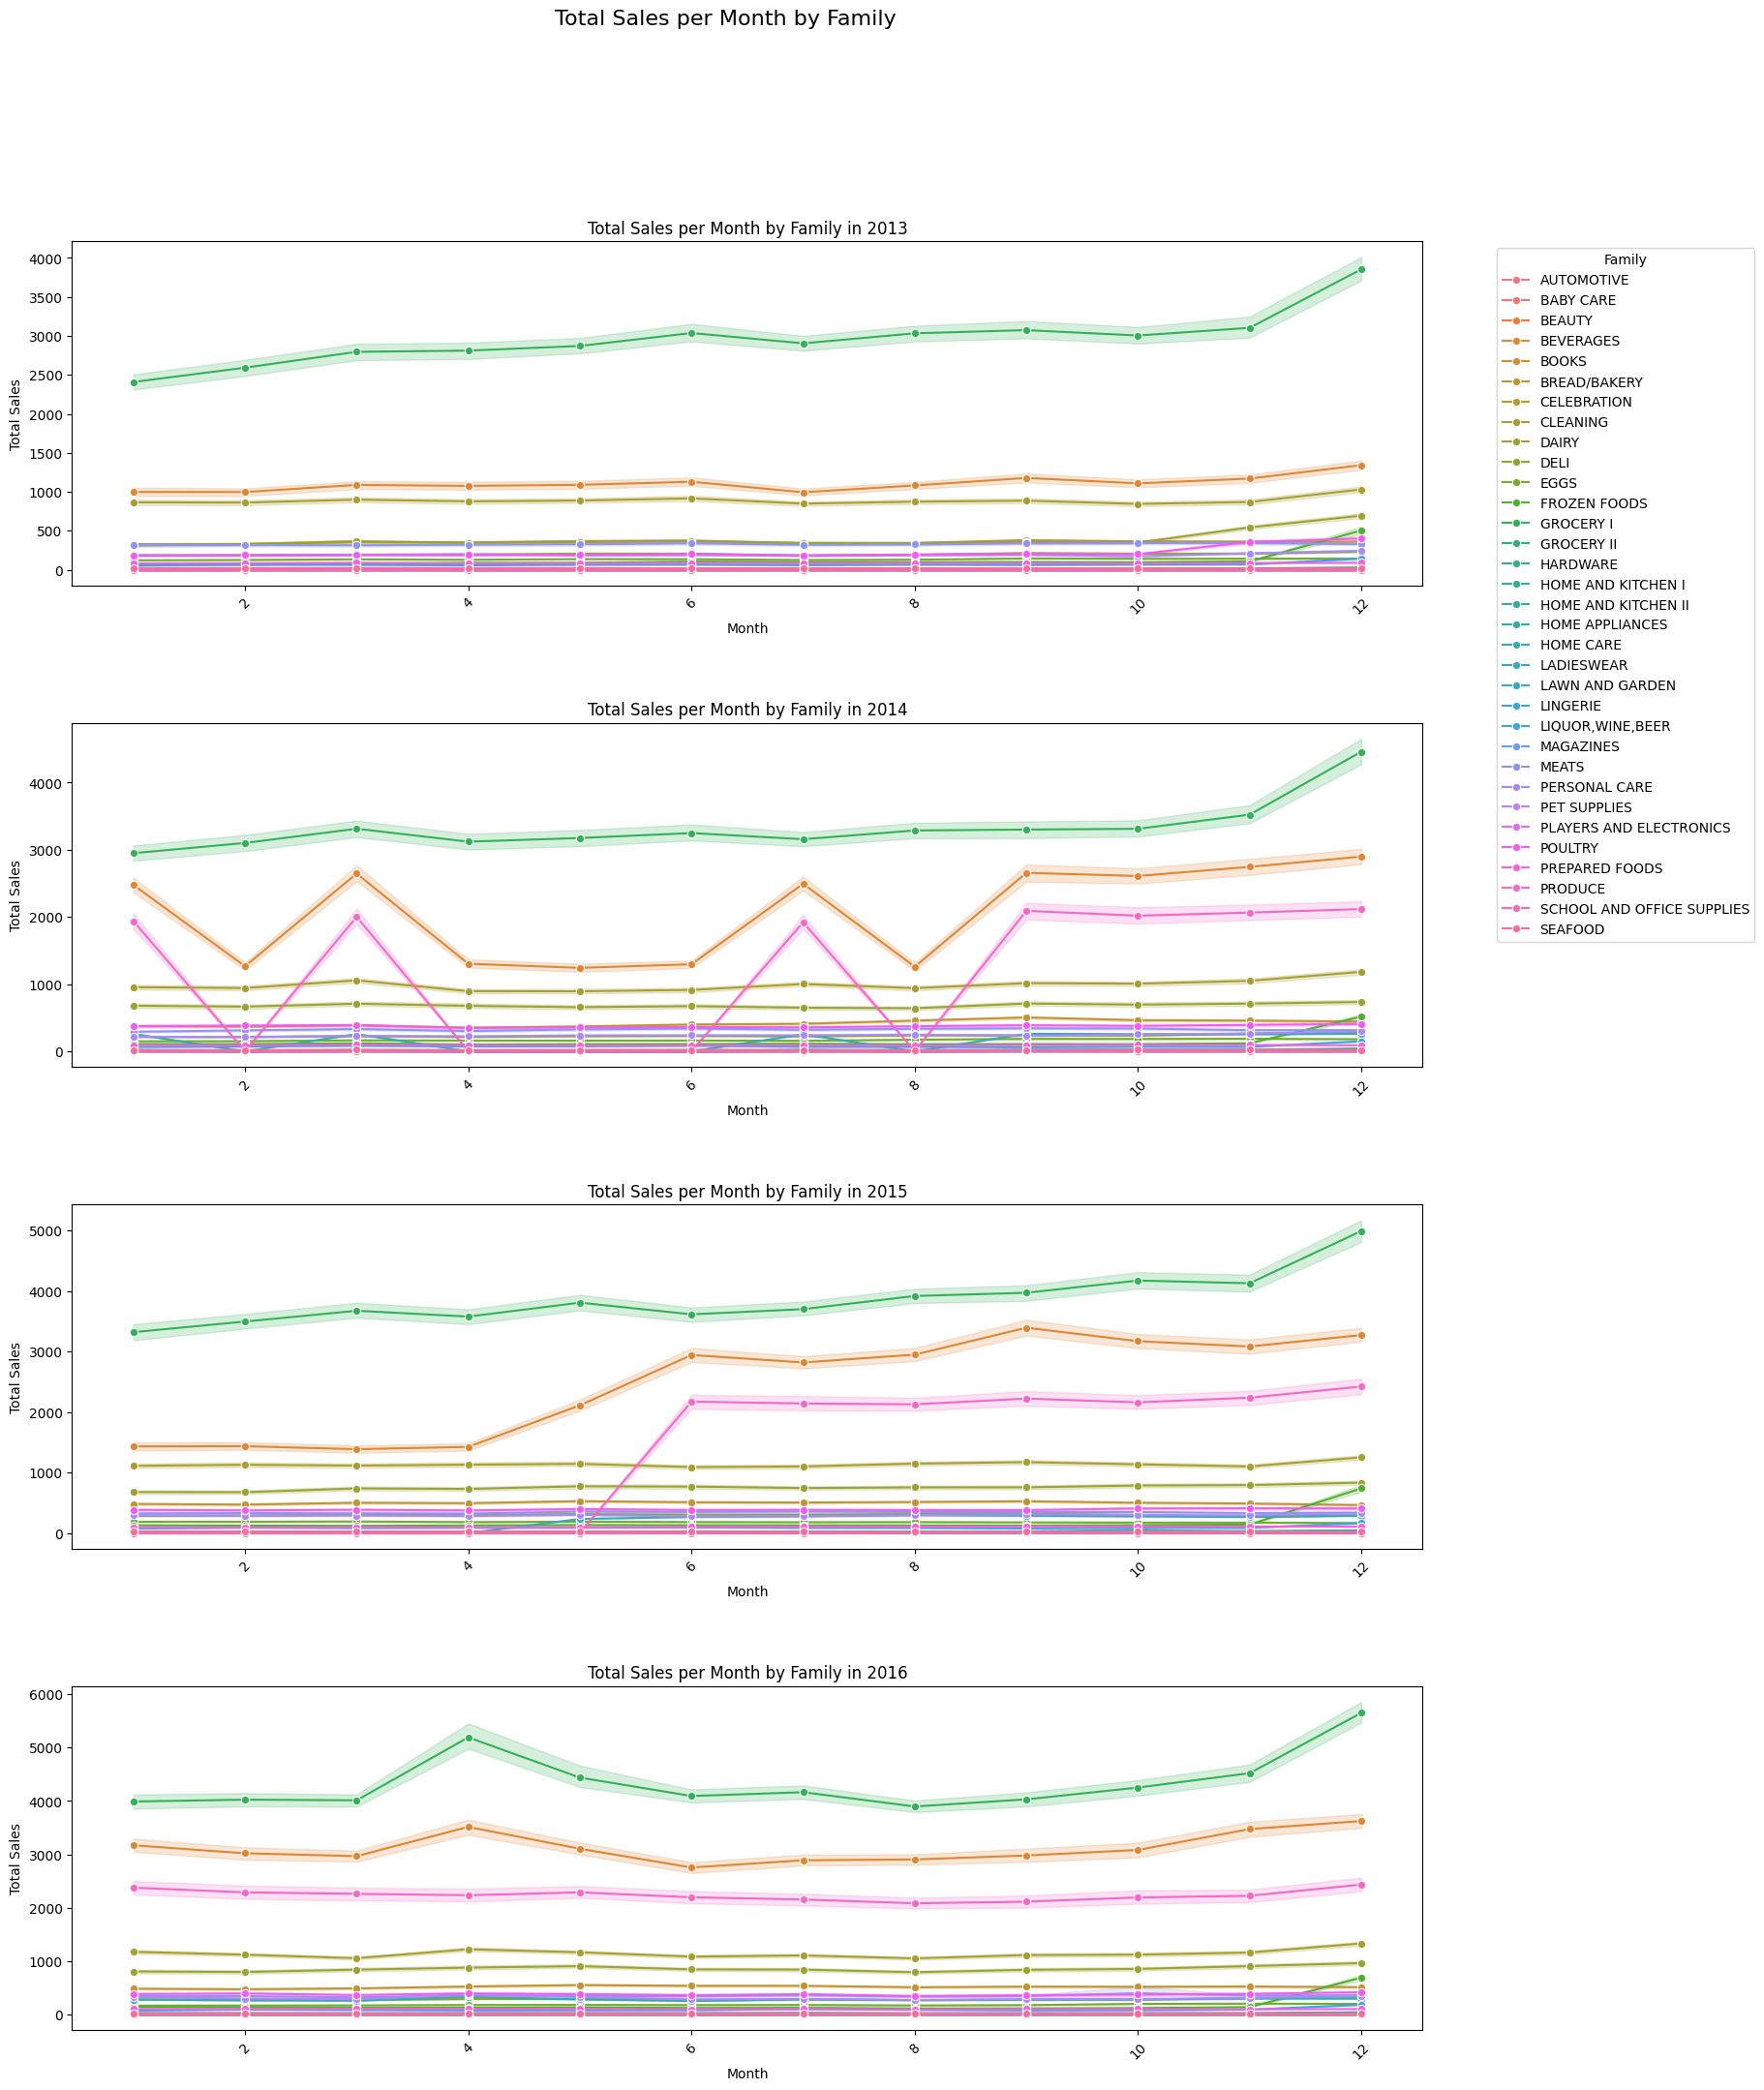

In [30]:
# Plotting for each year
years = df_train['year'].unique()

fig, axs = plt.subplots(len(years), figsize=(18, 24))
fig.suptitle('Total Sales per Month by Family', fontsize=16)
fig.subplots_adjust(hspace=0.4)  # Add space between subplots

for i, year in enumerate(years):
    axs[i].set_title(f'Total Sales per Month by Family in {year}')
    sns.lineplot(data=df_train[df_train['year'] == year], 
                 x='month', y='sales', hue='family', marker='o', legend='brief' if i == 0 else False, ax=axs[i])
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Total Sales')
    axs[i].tick_params(axis='x', rotation=45)
    if i == 0:
        axs[i].legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plots
plt.show()

- Conclusions

1. In December sales increase so there is a seasonality
2. Some items are more sold the  others, most of them are below 1000 sales in all years

C:\Users\mwuillau\AppData\Local\Temp\ipykernel_5972\741453743.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_per_year, x='year', y='sales', palette='viridis')


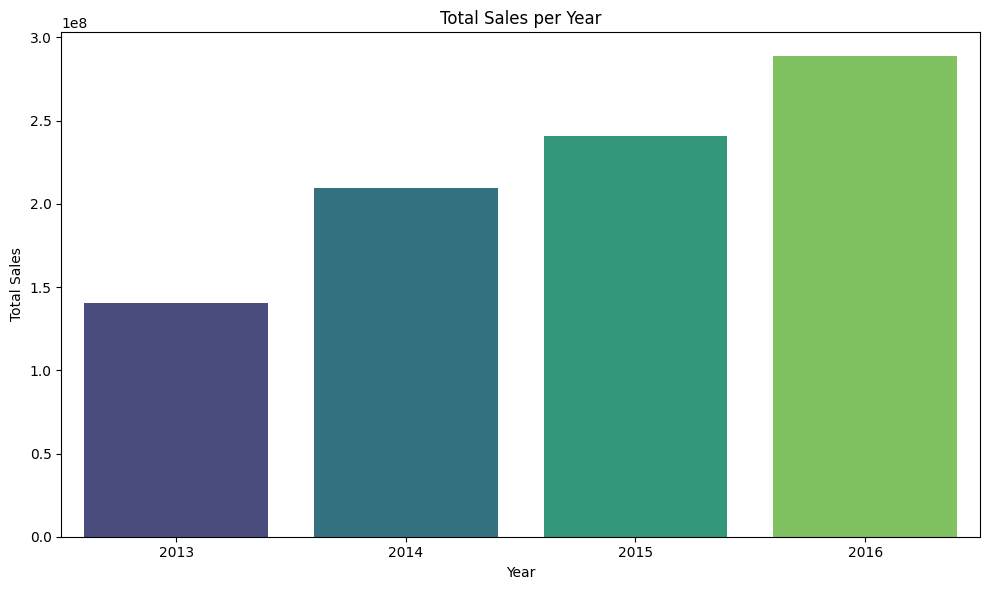

In [31]:
# Grouping by year and summing the sales
sales_per_year = df_train.groupby('year')['sales'].sum().reset_index()

# Creating a bar plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_per_year, x='year', y='sales', palette='viridis')
plt.title('Total Sales per Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.tight_layout()

# Display the plot
plt.show()

- Conclusion

1. There is a tendency for sales to increase over the years

#### Add Feature in_store_list to check if the store sales the product

In [142]:
# Filter the dataset to only include rows where sales are greater than 0
filtered_data = df_train[df_train['sales'] > 0]

# Create a dictionary mapping each store to the unique families that have been sold at least once
store_family_dict = filtered_data.groupby('store_nbr')['family'].unique().to_dict()
df_train['in_store_list'] = df_train.apply(lambda row: 1 if row['family'] in store_family_dict.get(row['store_nbr'], []) else 0, axis=1)
df_test['in_store_list'] = df_test.apply(lambda row: 1 if row['family'] in store_family_dict.get(row['store_nbr'], []) else 0, axis=1)
df_submission['in_store_list'] = df_submission.apply(lambda row: 1 if row['family'] in store_family_dict.get(row['store_nbr'], []) else 0, axis=1)

#### Add feature Store day of to check if the stores do not sell products in a specific day

In [143]:
zero_sales_days = df_train.groupby(['date', 'store_nbr'])['sales'].sum()
zero_sales_days = zero_sales_days[zero_sales_days == 0]
# Create a DataFrame with zero sales days


zero_sales_days_df = zero_sales_days.reset_index()
zero_sales_days_df['year'] = zero_sales_days_df['date'].dt.year
zero_sales_days_df['day_month'] = zero_sales_days_df['date'].dt.strftime('%m-%d')
zero_sales_days_df['day_off_store'] = 1

zero_sales_days_df_rep = zero_sales_days_df.groupby(['store_nbr', 'day_month']).size()
zero_sales_days_df_rep.name = 'day_rep'
zero_sales_days_df_rep = zero_sales_days_df_rep.reset_index()

In [144]:
# days_off_store = zero_sales_days_df_rep[zero_sales_days_df_rep['day_rep'] == 4]
# days_off_store['day_off_store'] = 1
# days_off_store.to_csv('./Data/step1/days_off_store.csv', index=False)
days_off_store = pd.read_csv('./Data/step1/days_off_store.csv')
days_off_store.head()

C:\Users\mwuillau\AppData\Local\Temp\ipykernel_5972\420751451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_off_store['day_off_store'] = 1


,store_nbr,day_month,day_rep,day_off_store
0,1,01-01,4,1
2,1,12-25,4,1
3,2,01-01,4,1
4,2,12-25,4,1
5,3,01-01,4,1


In [145]:
df_train_do = df_train.merge(zero_sales_days_df[['store_nbr', 'date', 'day_off_store']], on=['store_nbr', 'date'], how='left')
df_train_do['day_off_store'] = df_train_do['day_off_store'].fillna(0)

In [146]:
df_test['day_month'] = df_test['date'].dt.strftime('%m-%d')
df_submission['day_month'] = df_submission['date'].dt.strftime('%m-%d')


df_test_do = df_test.merge(days_off_store[['day_month', 'store_nbr','day_off_store']], on=['day_month', 'store_nbr'], how='left')
df_submission_do = df_submission.merge(days_off_store[['day_month', 'store_nbr','day_off_store']], on=['day_month', 'store_nbr'], how='left')

df_test_do['day_off_store'] = df_test_do['day_off_store'].fillna(0)
df_submission_do['day_off_store'] = df_submission_do['day_off_store'].fillna(0)

In [148]:
df_train.shape, df_test.shape, df_submission.shape

((2603502, 10), (404514, 11), (28512, 10))

In [150]:
df_test = df_test_do
df_train = df_train_do
df_submission = df_submission_do

### Encoding

In [162]:
X_train, y_train = df_train[['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store']], df_train['sales']
X_test, y_test = df_test[['store_nbr','family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store']], df_test['sales']
X_submission = df_submission[['id', 'store_nbr','family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store']]

- One Hot Encoding

In [163]:

def encode_one_how(X_train, X_test, X_submission, categorical_cols):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train[categorical_cols])

    # Transform the training and test data
    train_encoded_array = encoder.transform(X_train[categorical_cols])
    test_encoded_array = encoder.transform(X_test[categorical_cols])
    submission_encoded_array = encoder.transform(X_submission[categorical_cols])
    

    # Create DataFrames with the encoded data
    train_encoded_df = pd.DataFrame(train_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
    test_encoded_df = pd.DataFrame(test_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)
    submission_encoded_df = pd.DataFrame(submission_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_submission.index)
    

    # Concatenate the original DataFrame (excluding the original categorical columns) with the encoded DataFrame
    X_train_encoded = pd.concat([X_train.drop(columns=categorical_cols), train_encoded_df], axis=1)
    X_test_encoded = pd.concat([X_test.drop(columns=categorical_cols), test_encoded_df], axis=1)
    X_submission_encoded = pd.concat([X_submission.drop(columns=categorical_cols), submission_encoded_df], axis=1)
    
    return X_train_encoded, X_test_encoded, X_submission_encoded
        

In [164]:
X_train_1, X_test_1, X_submission_1 = encode_one_how(X_train, X_test, X_submission, ['family', 'month', 'day_of_week'])

In [165]:
X_train_1.shape, X_test_1.shape, X_submission_1.shape

((2603502, 57), (404514, 57), (28512, 58))

- Cyclic Encoding

In [166]:
day_of_week_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

def cyclic_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col].astype(int) / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col].astype(int) / max_val)
    return data


def encode_cyclic_hot(X_train, X_test, X_submission):
    
    X_train['day_of_week'] = X_train['day_of_week'].map(day_of_week_mapping)
    X_test['day_of_week'] = X_test['day_of_week'].map(day_of_week_mapping)
    X_submission['day_of_week'] = X_submission['day_of_week'].map(day_of_week_mapping)
    
    
    X_train = cyclic_encode(X_train, 'month', 12)
    X_train = cyclic_encode(X_train, 'day_of_week', 7)
    X_test = cyclic_encode(X_test, 'month', 12)
    X_test = cyclic_encode(X_test, 'day_of_week', 7)
    
    X_submission = cyclic_encode(X_submission, 'month', 12)
    X_submission = cyclic_encode(X_submission, 'day_of_week', 7)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train[['family']])
    train_family_encoded = encoder.transform(X_train[['family']])
    test_family_encoded = encoder.transform(X_test[['family']])
    submission_family_encoded = encoder.transform(X_submission[['family']])
    
    train_family_df = pd.DataFrame(train_family_encoded, columns=encoder.get_feature_names_out(['family']), index=X_train.index)
    test_family_df = pd.DataFrame(test_family_encoded, columns=encoder.get_feature_names_out(['family']), index=X_test.index)
    submission_family_df = pd.DataFrame(submission_family_encoded, columns=encoder.get_feature_names_out(['family']), index=X_submission.index)
    
    X_train_encoded = pd.concat([X_train.drop(columns=['family', 'month', 'day_of_week']), train_family_df], axis=1)
    X_test_encoded = pd.concat([X_test.drop(columns=['family', 'month', 'day_of_week']), test_family_df], axis=1)
    X_submission_encoded = pd.concat([X_submission.drop(columns=['family', 'month', 'day_of_week']), submission_family_df], axis=1)
    
    return X_train_encoded, X_test_encoded, X_submission_encoded


In [167]:
X_train_2, X_test_2, X_submission_2 = encode_cyclic_hot(X_train, X_test, X_submission)

C:\Users\mwuillau\AppData\Local\Temp\ipykernel_5972\3018453640.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['day_of_week'] = X_train['day_of_week'].map(day_of_week_mapping)
C:\Users\mwuillau\AppData\Local\Temp\ipykernel_5972\3018453640.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['day_of_week'] = X_test['day_of_week'].map(day_of_week_mapping)
C:\Users\mwuillau\AppData\Local\Temp\ipykernel_5972\3018453640.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [168]:
X_train_2.shape, X_test_2.shape,  X_submission_2.shape

((2603502, 42), (404514, 42), (28512, 43))

### Models Evaluation

In [169]:
# Train and evaluate model for each store
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)





#### Compare Models and Training Sets - One Store Prediction

In [186]:
# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': GradientBoostingRegressor(random_state=42)
}

sets = {
    'One Hot Encoding on Month and Day of Week': [
        X_train_1[X_train_1['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_1['store_nbr'] == 10], 
        X_test_1[X_test_1['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_1['store_nbr'] == 10]
    ],
    'Cyclic Encoding on Month and Day of Week': [
        X_train_2[X_train_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_train[X_train_2['store_nbr'] == 10], 
        X_test_2[X_test_2['store_nbr'] == 10].drop(columns='store_nbr'), 
        y_test[X_test_2['store_nbr'] == 10]
    ],
    
}
def evaluate_models(models, sets):
    results = []

    for set_name, data in sets.items():
        X_train, y_train, X_test, y_test = data
        
        for model_name, model in models.items():
            # Train the model
            model.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test)
            y_pred[y_pred < 0] = 0
            # Calculate Mean Squared Error
            score = rmsle(y_test, y_pred)
            
            # Append results
            results.append({
                'Set': set_name,
                'Model': model_name,
                'RMSLE': score
            })
    return pd.DataFrame(results)

In [194]:
results = evaluate_models(models, sets)
results

,Set,Model,RMSLE
0,One Hot Encoding on Month and Day of Week,RandomForest,0.566007
1,One Hot Encoding on Month and Day of Week,XGBoost,1.680981
2,Cyclic Encoding on Month and Day of Week,RandomForest,0.568053
3,Cyclic Encoding on Month and Day of Week,XGBoost,1.668786


In [195]:
results.to_csv('./Data/step1/results.csv')

- The best result was in the Random Forest using one hot encoding for the months and days of the week

#### Train for all Stores 

In [189]:


def train_per_store(stores, X_train, y_train, X_test, y_test):
    all_y_true = []
    all_y_pred_rf = []
    models = {}

    for store_nbr in stores:
        print('Store', store_nbr)
        X_train_st = X_train[X_train['store_nbr'] == store_nbr].drop(columns=['store_nbr'])
        X_test_st = X_test[X_test['store_nbr'] == store_nbr].drop(columns=['store_nbr'])
        
        y_train_st = y_train[X_train['store_nbr'] == store_nbr]
        y_test_st = y_test[X_test['store_nbr'] == store_nbr]
        
        # Train Random Forest Regressor
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_train_st, y_train_st) 
        # Make predictions
        y_pred_rf = rf.predict(X_test_st)
        # Append true values and predictions to the lists
        all_y_true.extend(y_test_st)
        all_y_pred_rf.extend(y_pred_rf)
        
        
        models[store_nbr] = {
            'rf': rf
        }
    
    total_rmsle_rf = rmsle(np.array(all_y_true), np.array(all_y_pred_rf))

    return {
        'Random Forest': total_rmsle_rf,
        'models': models
    }
        
def predict_per_store(models, X_submission, model_name='rf'):
    stores = X_submission['store_nbr'].unique()
    predictions = {'id': [], 'sales': []}
    for store in stores:
        X_submission_st = X_submission[X_submission['store_nbr'] == store]
        ids = X_submission_st['id']
        X_submission_st = X_submission_st.drop(columns=['id', 'store_nbr'])
        y_pred = models[store][model_name].predict(X_submission_st)

        predictions['id'] += list(ids)
        predictions['sales'] += list(y_pred)
        
    predictions_df = pd.DataFrame(predictions)
    return predictions_df
        


In [190]:
stores = df_train['store_nbr'].unique()
result = train_per_store(stores, X_train_1, y_train, X_test_1, y_test)
print('RMLSE with One hot', result['Random Forest'])

Store 1
Store 10
Store 11
Store 12
Store 13
Store 14
Store 15
Store 16
Store 17
Store 18
Store 19
Store 2
Store 20
Store 21
Store 22
Store 23
Store 24
Store 25
Store 26
Store 27
Store 28
Store 29
Store 3
Store 30
Store 31
Store 32
Store 33
Store 34
Store 35
Store 36
Store 37
Store 38
Store 39
Store 4
Store 40
Store 41
Store 42
Store 43
Store 44
Store 45
Store 46
Store 47
Store 48
Store 49
Store 5
Store 50
Store 51
Store 52
Store 53
Store 54
Store 6
Store 7
Store 8
Store 9
RMLSE with One hot 0.7491712205086433


In [192]:
first_submission_df = predict_per_store(result['models'], X_submission_1)
first_submission_df.to_csv('./Data/submssions/submission_step1.csv', index=False)

### Save datasets

In [193]:
df_train.to_csv('./Data/step1/df_train.csv', index=False)
df_test.to_csv('./Data/step1/df_test.csv', index=False)
df_submission.to_csv('./Data/step1/df_submission.csv', index=False)